In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 5

In [2]:
directory_to_evaluate = '../result_files/[final] 2025-02-02 13-32-09 (range based, 0.001 tolerance)'


calculated_distances = pd.read_csv(f'{directory_to_evaluate}/distances.csv', sep=";")
crosses_water_lookup = pd.read_csv(f'{directory_to_evaluate}/crosses_water.csv', sep=";")
measured_times = pd.read_csv(f'{directory_to_evaluate}/computation_times.csv', sep=";")

In [3]:
APPROACH_RENAMING_MAP = {
    'OVERHEAD_GRAPH_256': 'Overhead Graph (n=256)',
    'OVERHEAD_GRAPH_512': 'Overhead Graph (n=512)',
    'OVERHEAD_GRAPH_1024': 'Overhead Graph (n=1024)',
    'HAVERSINE': 'Haversine', 'HAVERSINE_CIRCUITY': 'Haversine (Circuity)',
    'OSRM': 'OSRM',
    'BRIDGE_NO_REC': 'Bridge Route', 'BRIDGE_NO_REC_CIRCUITY': 'Bridge Route (Circuity)',
    'BRIDGE_SPLIT_NO_REC': 'Bridge Route Split', 'BRIDGE_SPLIT_NO_REC_CIRCUITY': 'Bridge Route Split (Circuity)',
    'BRIDGE_REC': 'Bridge Route Recalculated', 'BRIDGE_REC_CIRCUITY': 'Bridge Route Recalculated (Circuity)',
    'BRIDGE_SPLIT_REC': 'Bridge Route Split Recalculated', 'BRIDGE_SPLIT_REC_CIRCUITY': 'Bridge Route Split Recalculated (Circuity)',
    'WATER_GRAPH': 'Water Graphs', 'WATER_GRAPH_CIRCUITY': 'Water Graphs (Circuity)'
}

CIRCUITY_FACTOR_GERMANY = 1.32
DISTANCE_RANGES = [(1, 5_000), (5_001, 10_000), (10_001, 15_000), (15_001, 20_000), (20_001, 25_000),
                   (25_001, 30_000), (30_001, 35_000), (35_001, 40_000), (40_001, 45_000), (45_001, 50_000),
                   (50_001, 55_000)]

def rename_columns(dataframe: pd.DataFrame):
    if "avg_time_ms" in dataframe.columns:
        dataframe = dataframe.reset_index(drop=True)
        dataframe['avg_time_ms'] = dataframe['avg_time_ms'] * 1000
        dataframe = dataframe.rename(columns={'avg_time_ms': 'Avg. Time (µs)'})


    if "std_time_ms" in dataframe.columns:
        dataframe = dataframe.reset_index(drop=True)
        dataframe['std_time_ms'] = dataframe['std_time_ms'] * 1000
        dataframe = dataframe.rename(columns={'std_time_ms': 'Std. Time (µs)'})


    if "approach" in dataframe.columns:
        dataframe = dataframe.reset_index(drop=True)
        dataframe = dataframe.rename(columns={'approach': 'Approach'})

    return dataframe


def sort_by_approach(dataframe: pd.DataFrame):
    # Create a lookup dictionary from the custom order
    custom_order = ['OVERHEAD_GRAPH_256', 'OVERHEAD_GRAPH_512', 'OVERHEAD_GRAPH_1024',
                    'HAVERSINE', 'HAVERSINE_CIRCUITY',
                    'OSRM',
                    # 'BRIDGE_LINE', 'BRIDGE_LINE_CIRCUITY',
                    'BRIDGE_NO_REC', 'BRIDGE_NO_REC_CIRCUITY',
                    'BRIDGE_REC', 'BRIDGE_REC_CIRCUITY',
                    'BRIDGE_SPLIT_NO_REC', 'BRIDGE_SPLIT_NO_REC_CIRCUITY',
                    'BRIDGE_SPLIT_REC', 'BRIDGE_SPLIT_REC_CIRCUITY',
                    'WATER_GRAPH', 'WATER_GRAPH_CIRCUITY']
    order_dict = {value: index for index, value in enumerate(custom_order)}

    # Map the column to numeric values using the lookup dictionary
    dataframe['order'] = dataframe['approach'].map(order_dict)

    # Sort the DataFrame based on the numeric values and drop the order column
    dataframe_sorted = dataframe.sort_values(by='order').drop(columns=['order'])

    approach_column_name = "approach" if "approach" in dataframe_sorted.columns else "Approach"

    for k, v in APPROACH_RENAMING_MAP.items():
        dataframe_sorted.loc[dataframe_sorted[approach_column_name] == k, approach_column_name] = v

    dataframe_sorted = rename_columns(dataframe_sorted)

    return dataframe_sorted

# Random Path Analysis

## Path Length Distribution

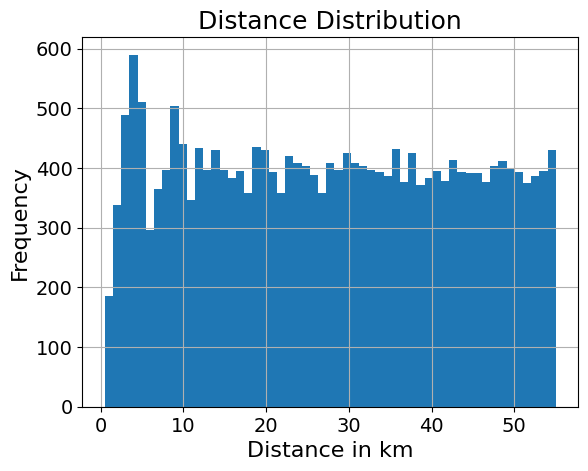

In [4]:
# distance distribution for using multiple districts
tmp = calculated_distances.copy()
tmp['distance_km'] = tmp['distance_meters'] / 1000
tmp[tmp['approach'] == "OSRM"]['distance_km'].hist(bins=55)

# add title and labels, increase font size
plt.title('Distance Distribution', fontsize=18)
plt.xlabel('Distance in km', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

# increase font size of ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## Distance Distribution Below 15km

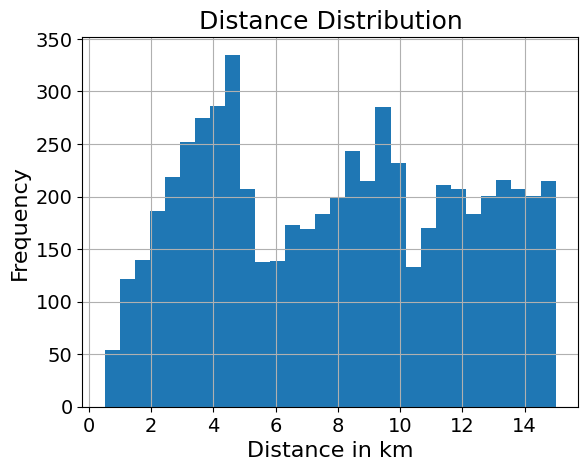

In [5]:
# distance distribution for using multiple districts
tmp = calculated_distances.copy()
tmp['distance_km'] = tmp['distance_meters'] / 1000
tmp = tmp[tmp['distance_meters'] < 15_000]
tmp[tmp['approach'] == "OSRM"]['distance_km'].hist(bins=30)

# add title and labels, increase font size
plt.title('Distance Distribution', fontsize=18)
plt.xlabel('Distance in km', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

# increase font size of ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

## Analyze Percentage of Crossed Water Areas and River per Distance Range

In [6]:
only_distances = calculated_distances[['approach', 'distance_meters', 'start_loc', 'dest_loc']].groupby(['approach', 'start_loc', 'dest_loc']).first().reset_index()
distance_truth = only_distances[only_distances['approach'] == 'OSRM'][['distance_meters', 'start_loc', 'dest_loc']]
distance_truth = distance_truth.merge(crosses_water_lookup, on=['start_loc', 'dest_loc'])

In [7]:
results = {}

for distance_range in DISTANCE_RANGES:
        results[f'{distance_range[0]}-{distance_range[1]}'] = {}
        _filtered = distance_truth[(distance_truth['distance_meters'] >= distance_range[0]) &
                                      (distance_truth['distance_meters'] < distance_range[1])]

        results[f'{distance_range[0]}-{distance_range[1]}']["Crosses Water"] = _filtered['crosses_water'].mean() * 100
        results[f'{distance_range[0]}-{distance_range[1]}']["Crosses River"] = _filtered['crosses_river'].mean() * 100

df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Distance (km)'})
df['Distance (km)'] = df['Distance (km)'].apply(lambda x: f"{(int(x.split('-')[0])-1)/1000:.0f}-{(int(x.split('-')[1]))/1000:.0f}")

os.makedirs("Figures and Tables", exist_ok=True)
df.style.hide(axis="index").highlight_min(
    axis=0, props="textbf:--rwrap;").format(
    decimal='.', thousands=',', precision=2, na_rep="-").to_latex(
   f"Figures and Tables/water_area_crossed_per_distance.tex",
    hrules=True)

df

,Distance (km),Crosses Water,Crosses River
0,0-5,96.95,84.20
1,5-10,99.15,88.80
...,...,...,...
9,45-50,99.95,96.85
10,50-55,100.00,96.65


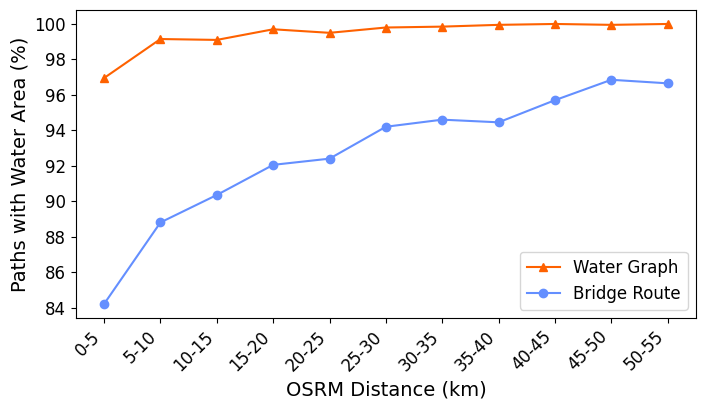

In [8]:
x = [i for i in range(0,11)]

color_list = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
marker_list = ['o', 's', 'v', '^', '>']


plt.plot(x, df['Crosses Water'].to_list(), marker=marker_list[3], color=color_list[3], label="Water Graph")
plt.plot(x, df['Crosses River'].to_list(), marker=marker_list[0], color=color_list[0], label="Bridge Route")

plt.legend(fontsize=12)

# change labels for x-axis
plt.xticks(x, df['Distance (km)'].to_list(), rotation=45, fontsize=12, ha='right')

plt.ylabel('Paths with Water Area (%)', fontsize=14)
plt.xlabel('OSRM Distance (km)', fontsize=14)

# add ticks for y-axis
plt.yticks(fontsize=12)

# set figure size
plt.gcf().set_size_inches(8, 4)

plt.savefig("Figures and Tables/water_area_crossed_per_distance.pdf", dpi=300, bbox_inches='tight')
plt.show()

# Computation Time by Approach

In [9]:
grouped = measured_times.groupby('approach')
df = grouped[['avg_time_ms', 'std_time_ms']].mean().reset_index().sort_values('avg_time_ms')
# df = df[df['approach'] != 'WATER_GRAPH_CIRCUITY']
df = sort_by_approach(df)

# df.rename(columns={'approach': 'Approach', 'avg_time_ms': 'Avg. Time (ms)', 'std_time_ms': 'Std. Time (ms)'})


# (range based)
tex_file_name = "range_based"

if "lower Franconia BB" in directory_to_evaluate:
    tex_file_name = "single_district"
elif "multiple districts" in directory_to_evaluate:
    "multiple_districts"

os.makedirs("Figures and Tables", exist_ok=True)
df.style.hide(axis="index").highlight_min(
    axis=0, props="textbf:--rwrap;", subset=pd.IndexSlice[:, ['Avg. Time (µs)', 'Std. Time (µs)']]).format(
    decimal='.', thousands=',', precision=3, na_rep="-").to_latex(
   f"Figures and Tables/{tex_file_name}.tex",
    hrules=True)

df

,Approach,Avg. Time (µs),Std. Time (µs)
0,Overhead Graph (n=256),6.549747,1.605248
1,Overhead Graph (n=512),6.917686,1.597407
...,...,...,...
9,Water Graphs,225.624208,46.247821
10,Water Graphs (Circuity),226.508209,46.403612


# Distance Deviation per Approach

In [10]:
only_distances = calculated_distances[['approach', 'distance_meters', 'start_loc', 'dest_loc']].groupby(['approach', 'start_loc', 'dest_loc']).first().reset_index()
distance_truth = only_distances[only_distances['approach'] == 'OSRM'][['distance_meters', 'start_loc', 'dest_loc']]
distance_truth = distance_truth.merge(crosses_water_lookup, on=['start_loc', 'dest_loc'])

# merge only distances with truth distances on start_loc and dest_loc
only_distances = only_distances.merge(distance_truth, on=['start_loc', 'dest_loc'], suffixes=('', '_truth'))

# distances can be zero, if the start and destination are the same. This can happen if points are close 
# to each other and snapped to the same object by osrm
only_distances = only_distances[only_distances['distance_meters_truth'] != 0]

# Overall Distance Deviation and Metrics

## Ignoring if water area is crossed

In [11]:
results = {}

for approach in only_distances['approach'].unique().tolist():
    if approach == 'OSRM':
        continue
        
    _filtered = only_distances[(only_distances['approach'] == approach)]
    
    results[approach] = {
        'MAE': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
        'Std': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
        'RMSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean()**0.5,
        'MSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean(),
        'MAPE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
    }

    if approach in ['HAVERSINE', 'BRIDGE_LINE', 'BRIDGE_REC', 'BRIDGE_NO_REC', 'BRIDGE_SPLIT_REC', 'BRIDGE_SPLIT_NO_REC']:
        results[f'{approach}_CIRCUITY'] = {
            'MAE': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
            'Std': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
            'RMSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean() ** 0.5,
            'MSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean(),
            'MAPE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
        }

    # here we try multiplying the circuity factor to the water graph approach and see if the results are the same compared to the approach already incorporating the circuity factor!
    if approach in ['WATER_GRAPH']:
        results[f'{approach}_CIRCUITY_TEST'] = {
            'MAE': (CIRCUITY_FACTOR_GERMANY *_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
            'Std': (CIRCUITY_FACTOR_GERMANY *_filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
            'RMSE': ((CIRCUITY_FACTOR_GERMANY *_filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean() ** 0.5,
            'MSE': ((CIRCUITY_FACTOR_GERMANY *_filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean(),
            'MAPE': ((CIRCUITY_FACTOR_GERMANY *_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
        }

df = pd.DataFrame(results).T.reset_index(names=['approach'])
df = sort_by_approach(df)
df.rename(columns={'approach': 'Approach'}, inplace=True)

df

,Approach,MAE,Std,RMSE,MSE,MAPE
0,Overhead Graph (n=256),3419.486609,4925.514818,4944.213717,2.444525e+07,0.161253
1,Overhead Graph (n=512),3269.208834,5008.834213,5010.926524,2.510938e+07,0.161735
...,...,...,...,...,...,...
14,Water Graphs (Circuity),3191.682736,3971.074862,4592.067246,2.108708e+07,0.128941
15,WATER_GRAPH_CIRCUITY_TEST,3135.644876,4060.326360,4503.264585,2.027939e+07,0.128986


## Only distances with crossed water areas

In [12]:
results = {}

for approach in only_distances['approach'].unique().tolist():
    if approach == 'OSRM':
        continue
        
    _filtered = only_distances[(only_distances['approach'] == approach) & (only_distances['crosses_water'] == True)]
    
    results[approach] = {
        'MAE': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
        'Std': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
        'RMSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean()**0.5,
        'MSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean(),
        'MAPE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
    }


    if approach in ['HAVERSINE', 'BRIDGE_REC', 'BRIDGE_LINE', 'BRIDGE_NO_REC', 'BRIDGE_SPLIT_REC', 'BRIDGE_SPLIT_NO_REC']:
        results[f'{approach}_CIRCUITY'] = {
            'MAE': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
            'Std': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
            'RMSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean() ** 0.5,
            'MSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean(),
            'MAPE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
        }

df = pd.DataFrame(results).T.reset_index(names=['approach'])
df = sort_by_approach(df)
df.rename(columns={'approach': 'Approach'}, inplace=True)

df

,Approach,MAE,Std,RMSE,MSE,MAPE
0,Overhead Graph (n=256),3427.988430,4934.655621,4953.321283,2.453539e+07,0.160848
1,Overhead Graph (n=512),3276.822633,5016.744322,5018.850299,2.518886e+07,0.161130
...,...,...,...,...,...,...
13,Water Graphs,8219.954515,5464.743620,9855.176511,9.712450e+07,0.295011
14,Water Graphs (Circuity),3200.382066,3977.629683,4600.290811,2.116268e+07,0.128624


## Only distances with crossed rivers

In [13]:
results = {}

for approach in only_distances['approach'].unique().tolist():
    if approach == 'OSRM':
        continue
        
    _filtered = only_distances[(only_distances['approach'] == approach) & (only_distances['crosses_river'] == True)]
    
    results[approach] = {
        'MAE': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
        'Std': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
        'RMSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean()**0.5,
        'MSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean(),
        'MAPE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
    }
    

    if approach in ['HAVERSINE', 'BRIDGE_REC', 'BRIDGE_LINE', 'BRIDGE_NO_REC', 'BRIDGE_SPLIT_REC', 'BRIDGE_SPLIT_NO_REC']:
        results[f'{approach}_CIRCUITY'] = {
            'MAE': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
            'Std': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
            'RMSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean() ** 0.5,
            'MSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean(),
            'MAPE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
        }

df = pd.DataFrame(results).T.reset_index(names=['approach'])
df = sort_by_approach(df)
df.rename(columns={'approach': 'Approach'}, inplace=True)

df

,Approach,MAE,Std,RMSE,MSE,MAPE
0,Overhead Graph (n=256),3459.355781,4974.032212,4991.231506,2.491239e+07,0.159119
1,Overhead Graph (n=512),3311.033739,5060.685528,5063.758998,2.564166e+07,0.159031
...,...,...,...,...,...,...
13,Water Graphs,8323.609948,5457.252274,9937.653655,9.875696e+07,0.293257
14,Water Graphs (Circuity),3229.563998,4003.809698,4624.647979,2.138737e+07,0.126829


## Only distances WITHOUT crossed water areas

In [14]:
results = {}

for approach in only_distances['approach'].unique().tolist():
    if approach == 'OSRM':
        continue
        
    _filtered = only_distances[(only_distances['approach'] == approach) & (only_distances['crosses_water'] == False)]
    
    results[approach] = {
        'MAE': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
        'Std': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
        'RMSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean()**0.5,
        'MSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean(),
        'MAPE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
    }

    if approach in ['HAVERSINE', 'BRIDGE_LINE', 'BRIDGE_REC', 'BRIDGE_NO_REC', 'BRIDGE_SPLIT_REC', 'BRIDGE_SPLIT_NO_REC']:
        results[f'{approach}_CIRCUITY'] = {
            'MAE': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
            'Std': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
            'RMSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean() ** 0.5,
            'MSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean(),
            'MAPE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
        }

df = pd.DataFrame(results).T.reset_index(names=['approach'])
df = sort_by_approach(df)
df.rename(columns={'approach': 'Approach'}, inplace=True)

df

,Approach,MAE,Std,RMSE,MSE,MAPE
0,Overhead Graph (n=256),1882.202726,2833.843397,2854.094443,8.145855e+06,0.234508
1,Overhead Graph (n=512),1892.495540,3290.445139,3277.055863,1.073910e+07,0.271095
...,...,...,...,...,...,...
13,Water Graphs,3423.254441,3567.951965,4933.937906,2.434374e+07,0.347894
14,Water Graphs (Circuity),1618.685704,2354.401769,2723.659473,7.418321e+06,0.186263


# Per Distance Range

In [15]:
def get_metric_per_range(only_distances_df: pd.DataFrame, distance_ranges, crosses_water: bool = False, crosses_river: bool = False, no_water_crossing: bool = False, mape_as_string: bool = False) -> dict:
    _only_distances_df = only_distances_df.copy()
    
    if crosses_water:
        _only_distances_df = _only_distances_df[_only_distances_df['crosses_water'] == True]
        
    if crosses_river:
        _only_distances_df = _only_distances_df[_only_distances_df['crosses_river'] == True]
    
    if no_water_crossing:
        _only_distances_df = _only_distances_df[(_only_distances_df['crosses_water'] == False) & (_only_distances_df['crosses_river'] == False)] 
    
    results = {}
    
    for distance_range in distance_ranges:
        results[f'{distance_range[0]}-{distance_range[1]}'] = {}
        
        for approach in _only_distances_df['approach'].unique().tolist():
            if approach == 'OSRM':
                continue      
        
            _filtered = _only_distances_df[(_only_distances_df['approach'] == approach) &
                                       (_only_distances_df['distance_meters_truth'] >= distance_range[0]) &
                                          (_only_distances_df['distance_meters_truth'] < distance_range[1])]
            

            if mape_as_string:
                # This cannot be the case but we do this for completeness!
                _filtered = _filtered[_filtered['distance_meters_truth'] != 0]

                # Calculate Absolute Percentage Errors (APE)
                _ape = np.abs((_filtered['distance_meters'] - _filtered['distance_meters_truth']) / _filtered['distance_meters_truth']) * 100
                results[f'{distance_range[0]}-{distance_range[1]}'][approach] = f"{_ape.mean():.2f} ± {_ape.std():.2f}"
            else:
                results[f'{distance_range[0]}-{distance_range[1]}'][approach] = {
                    'MAE': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
                    # 'Std': (_filtered['distance_meters'] - _filtered['distance_meters_truth']).std(),
                    'RMSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean()**0.5,
                    'MSE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth'])**2).mean(),
                    'MAPE': ((_filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
                }

            if approach in ['HAVERSINE', 'BRIDGE_LINE', 'BRIDGE_REC', 'BRIDGE_NO_REC', 'BRIDGE_SPLIT_REC', 'BRIDGE_SPLIT_NO_REC']:
                if mape_as_string:
                    _mean = ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean() * 100
                    _std = ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).std() * 100
                    results[f'{distance_range[0]}-{distance_range[1]}'][f'{approach}_CIRCUITY'] = f"{_mean:.2f} ± {_std:.2f}"
                else:
                    results[f'{distance_range[0]}-{distance_range[1]}'][f'{approach}_CIRCUITY'] = {
                        'MAE': (CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs().mean(),
                        'RMSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean() ** 0.5,
                        'MSE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']) ** 2).mean(),
                        'MAPE': ((CIRCUITY_FACTOR_GERMANY * _filtered['distance_meters'] - _filtered['distance_meters_truth']).abs() / _filtered['distance_meters_truth']).mean()
                    }
    
    return results

In [16]:
def get_times_per_range(measured_times_df: pd.DataFrame, distance_ranges, scale_times_µs: bool=False, crosses_water: bool = False, crosses_river: bool = False, no_water_crossing: bool = False, as_string: bool = False) -> dict:
    _measured_times_df = measured_times_df.copy()

    if crosses_water:
        _measured_times_df = _measured_times_df[_measured_times_df['crosses_water'] == True]

    if crosses_river:
        _measured_times_df = _measured_times_df[_measured_times_df['crosses_river'] == True]

    if no_water_crossing:
        _measured_times_df = _measured_times_df[(_measured_times_df['crosses_water'] == False) & (_measured_times_df['crosses_river'] == False)]

    results = {}

    for distance_range in distance_ranges:
        results[f'{distance_range[0]}-{distance_range[1]}'] = {}

        for approach in _measured_times_df['approach'].unique().tolist():
            _filtered = _measured_times_df[(_measured_times_df['approach'] == approach) &
                                       (_measured_times_df['distance_meters_truth'] >= distance_range[0]) &
                                          (_measured_times_df['distance_meters_truth'] < distance_range[1])]

            if scale_times_µs:
                _filtered.loc[:, 'avg_time_ms'] = _filtered['avg_time_ms'] * 1000

            if as_string:
                results[f'{distance_range[0]}-{distance_range[1]}'][approach] = f"{_filtered['avg_time_ms'].mean():.2f} ± {_filtered['avg_time_ms'].std():.2f}"
            else:
                results[f'{distance_range[0]}-{distance_range[1]}'][approach] = {
                    'avg': _filtered['avg_time_ms'].mean(),
                    'std': _filtered['avg_time_ms'].std(),
                }

    return results

In [17]:
def filter_df(only_distances_df: pd.DataFrame, distance_range: tuple[int, int] | None = None,
              crosses_water: bool = False, crosses_river: bool = False, no_water_crossing: bool = False) -> dict:
    _only_distances_df = only_distances_df.copy()
    
    if crosses_water:
        _only_distances_df = _only_distances_df[_only_distances_df['crosses_water'] == True]
        
    if crosses_river:
        _only_distances_df = _only_distances_df[_only_distances_df['crosses_river'] == True]
    
    if no_water_crossing:
        _only_distances_df = _only_distances_df[(_only_distances_df['crosses_water'] == False) & (_only_distances_df['crosses_river'] == False)] 
    
    if distance_range is not None:
            _only_distances_df = _only_distances_df[(_only_distances_df['distance_meters_truth'] >= distance_range[0]) &
                                  (_only_distances_df['distance_meters_truth'] < distance_range[1])]
    
    return results

## All Distances (ignoring if water area is crossed)

In [18]:
distance_ranges_results = get_metric_per_range(only_distances, DISTANCE_RANGES)

for distance_range in DISTANCE_RANGES:
    _df = pd.DataFrame(distance_ranges_results[f'{distance_range[0]}-{distance_range[1]}']).T.sort_values('MAPE', ascending=True)
    num_distances = distance_truth[(distance_truth['distance_meters'] >= distance_range[0]) & (distance_truth['distance_meters'] < distance_range[1])].shape[0]
    print(f'{distance_range[0]/1000:.0f}-{distance_range[1]/1000:.0f}km ({num_distances} samples)\n---')
    print(_df.head())
    print()

0-5km (2000 samples)
---
                                     MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY          568.173769   810.435301  6.568054e+05  0.177125
HAVERSINE_CIRCUITY            690.782962   968.831629  9.386347e+05  0.209014
BRIDGE_REC_CIRCUITY           723.423379  1275.660805  1.627310e+06  0.241917
BRIDGE_SPLIT_REC_CIRCUITY     738.357226  1382.052012  1.910068e+06  0.248530
BRIDGE_SPLIT_NO_REC_CIRCUITY  756.628422  1448.995689  2.099589e+06  0.255833

5-10km (2000 samples)
---
                                      MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY          1246.924936  1661.905153  2.761929e+06  0.157878
BRIDGE_REC_CIRCUITY           1466.322441  2471.745870  6.109528e+06  0.185363
BRIDGE_SPLIT_REC_CIRCUITY     1467.743886  2468.060621  6.091323e+06  0.185404
HAVERSINE_CIRCUITY            1527.965411  1999.425537  3.997702e+06  0.193581
BRIDGE_SPLIT_NO_REC_CIRCUITY  1554.133740  2724.369855  7.422191e+06  0.196218

10-15

## Distances with water area crossed

In [19]:
distance_ranges_results = get_metric_per_range(only_distances, DISTANCE_RANGES, crosses_water=True)

for distance_range in DISTANCE_RANGES:
    _df = pd.DataFrame(distance_ranges_results[f'{distance_range[0]}-{distance_range[1]}']).T.sort_values('MAPE', ascending=True)
    num_distances = distance_truth[(distance_truth['distance_meters'] >= distance_range[0]) &
                                   (distance_truth['distance_meters'] < distance_range[1]) &
                                   (distance_truth['crosses_water'] == True)].shape[0]
    print(f'{distance_range[0]/1000:.0f}-{distance_range[1]/1000:.0f}km ({num_distances} samples)\n---')
    print(_df.head())
    print()

0-5km (1939 samples)
---
                                  MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY       567.867341   807.867531  6.526499e+05  0.176174
HAVERSINE_CIRCUITY         694.333759   971.259753  9.433455e+05  0.209066
BRIDGE_REC_CIRCUITY        728.000147  1285.957134  1.653686e+06  0.243004
BRIDGE_SPLIT_REC_CIRCUITY  743.404687  1394.754229  1.945339e+06  0.249825
WATER_GRAPH                871.266779  1093.934669  1.196693e+06  0.255778

5-10km (1983 samples)
---
                                      MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY          1244.063903  1657.679920  2.747903e+06  0.157641
BRIDGE_REC_CIRCUITY           1465.342272  2474.712134  6.124200e+06  0.185361
BRIDGE_SPLIT_REC_CIRCUITY     1466.775903  2470.999730  6.105840e+06  0.185403
HAVERSINE_CIRCUITY            1527.513698  1998.567130  3.994271e+06  0.193649
BRIDGE_SPLIT_NO_REC_CIRCUITY  1553.906366  2729.123834  7.448117e+06  0.196309

10-15km (1982 samples)


## Distances with rivers crossed

In [20]:
distance_ranges_results = get_metric_per_range(only_distances, DISTANCE_RANGES, crosses_river=True)

for distance_range in DISTANCE_RANGES:
    _df = pd.DataFrame(distance_ranges_results[f'{distance_range[0]}-{distance_range[1]}']).T.sort_values('MAPE', ascending=True)
    num_distances = distance_truth[(distance_truth['distance_meters'] >= distance_range[0]) &
                                   (distance_truth['distance_meters'] < distance_range[1]) &
                                   (distance_truth['crosses_river'] == True)].shape[0]
    print(f'{distance_range[0]/1000:.0f}-{distance_range[1]/1000:.0f}km ({num_distances} samples)\n---')
    print(_df.head())
    print()

0-5km (1684 samples)
---
                                  MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY       563.633152   801.502823  6.424068e+05  0.171441
HAVERSINE_CIRCUITY         698.632175   977.987863  9.564603e+05  0.209079
BRIDGE_REC_CIRCUITY        738.451391  1332.506109  1.775573e+06  0.248557
WATER_GRAPH                861.489887  1085.602321  1.178532e+06  0.249430
BRIDGE_SPLIT_REC_CIRCUITY  755.133676  1452.646278  2.110181e+06  0.256011

5-10km (1776 samples)
---
                                      MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY          1239.539564  1656.940842  2.745453e+06  0.156690
BRIDGE_REC_CIRCUITY           1471.598338  2542.150623  6.462530e+06  0.185751
BRIDGE_SPLIT_REC_CIRCUITY     1474.604848  2539.095453  6.447006e+06  0.185961
HAVERSINE_CIRCUITY            1542.421873  2022.207867  4.089325e+06  0.195168
BRIDGE_SPLIT_NO_REC_CIRCUITY  1571.890719  2818.817271  7.945731e+06  0.198138

10-15km (1807 samples)


## Distances that do not cross water

In [21]:
distance_ranges_results = get_metric_per_range(only_distances, DISTANCE_RANGES, no_water_crossing=True)

for distance_range in DISTANCE_RANGES:
    _df = pd.DataFrame(distance_ranges_results[f'{distance_range[0]}-{distance_range[1]}']).T.sort_values('MAPE', ascending=True)
    num_distances = distance_truth[(distance_truth['distance_meters'] >= distance_range[0]) &
                                   (distance_truth['distance_meters'] < distance_range[1]) &
                                   (distance_truth['crosses_water'] == False) & (distance_truth['crosses_river'] == False)].shape[0]
    print(f'{distance_range[0]/1000:.0f}-{distance_range[1]/1000:.0f}km ({num_distances} samples)\n---')
    print(_df.head())
    print()

0-5km (61 samples)
---
                                     MAE        RMSE            MSE      MAPE
WATER_GRAPH_CIRCUITY          577.914146  888.196801  788893.558101  0.207367
HAVERSINE_CIRCUITY            577.914154  888.196815  788893.581398  0.207367
BRIDGE_SPLIT_REC_CIRCUITY     577.914158  888.196817  788893.586199  0.207367
BRIDGE_SPLIT_NO_REC_CIRCUITY  577.914158  888.196817  788893.586199  0.207367
BRIDGE_NO_REC_CIRCUITY        577.942171  888.213431  788923.099688  0.207380

5-10km (17 samples)
---
                                      MAE         RMSE           MSE      MAPE
WATER_GRAPH_CIRCUITY          1580.656058  2097.146380  4.398023e+06  0.185589
BRIDGE_NO_REC_CIRCUITY        1580.656249  2097.146542  4.398024e+06  0.185589
BRIDGE_SPLIT_REC_CIRCUITY     1580.656249  2097.146542  4.398024e+06  0.185589
BRIDGE_REC_CIRCUITY           1580.656249  2097.146542  4.398024e+06  0.185589
BRIDGE_SPLIT_NO_REC_CIRCUITY  1580.656249  2097.146542  4.398024e+06  0.185589

10-15km (

# Plot Metric per Distance Range

In [22]:
distance_ranges_results = get_metric_per_range(only_distances, DISTANCE_RANGES, crosses_river=True)

approaches_to_monitor = ['BRIDGE_NO_REC_CIRCUITY', 'OVERHEAD_GRAPH_1024', 'HAVERSINE_CIRCUITY', 'WATER_GRAPH_CIRCUITY']

plotting_data = {
    'x': [],
    'x_names': [],
    'approach_names': approaches_to_monitor,
    'MAE': {},
    'RMSE': {},
    'MAPE': {}
}

for distance_range in DISTANCE_RANGES:
    plotting_data['x'].append(distance_range[1]/1000)
    plotting_data['x_names'].append(f'{distance_range[0]/1000:.0f}-{distance_range[1]/1000:.0f}')

    _df = pd.DataFrame(distance_ranges_results[f'{distance_range[0]}-{distance_range[1]}']).T
    for approach in approaches_to_monitor:
        if approach not in plotting_data['MAE']:
            plotting_data['MAE'][approach] = []
            plotting_data['RMSE'][approach] = []
            plotting_data['MAPE'][approach] = []

        plotting_data['MAE'][approach].append(round(float(_df.loc[approach, 'MAE']), 3))
        plotting_data['RMSE'][approach].append(round(float(_df.loc[approach, 'RMSE']), 3))
        plotting_data['MAPE'][approach].append(round(float(_df.loc[approach, 'MAPE']), 3))

## MAE Plot

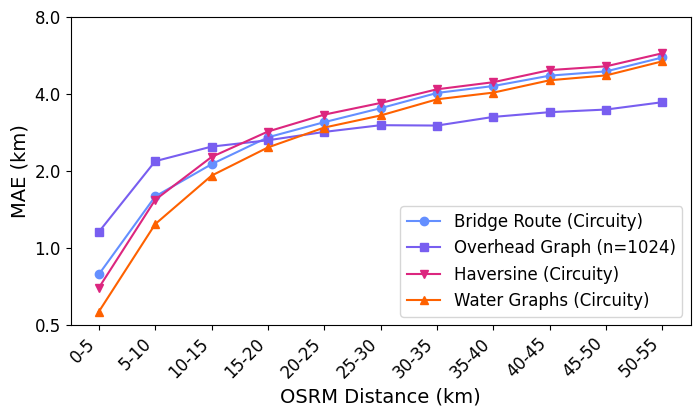

In [23]:
x = plotting_data['x']

color_list = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
marker_list = ['o', 's', 'v', '^', '>']

for i, approach in enumerate(plotting_data['approach_names']):
    _y = [i / 1000.0 for i in plotting_data['MAE'][approach]]
    plt.plot(x, _y, marker=marker_list[i], color=color_list[i], label=APPROACH_RENAMING_MAP[approach])

plt.legend(fontsize=12)


plt.xticks(x, plotting_data['x_names'], rotation=45, fontsize=12, ha='right')
plt.xlabel('OSRM Distance (km)', fontsize=14)

plt.yticks(fontsize=12)
plt.ylabel('MAE (km)', fontsize=14)

# set figure size
plt.gcf().set_size_inches(8, 4)

# log scale for y-axis
plt.yscale('log')
plt.yticks([0.5, 1, 2, 4, 8], ['0.5', '1.0', '2.0', '4.0', '8.0'], fontsize=12)
plt.gca().minorticks_off()

plt.savefig("Figures and Tables/MAE_per_distance_range.pdf", dpi=300, bbox_inches='tight')

## MAPE Plot

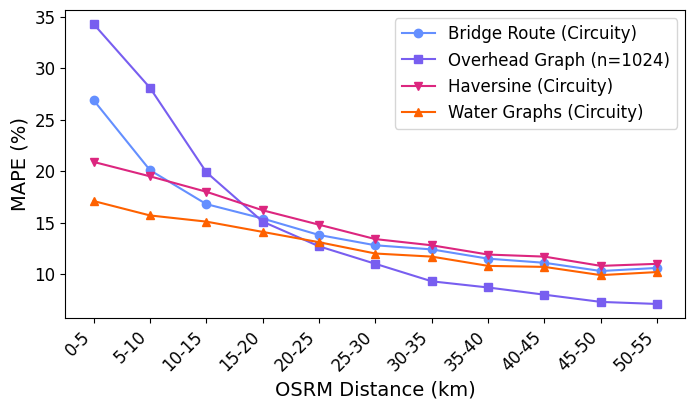

In [24]:
x = plotting_data['x']

color_list = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
marker_list = ['o', 's', 'v', '^', '>']

for i, approach in enumerate(plotting_data['approach_names']):
    _y = [i * 100 for i in plotting_data['MAPE'][approach]]
    plt.plot(x, _y, marker=marker_list[i], color=color_list[i], label=APPROACH_RENAMING_MAP[approach])

plt.legend(fontsize=12)

# change labels for x-axis
plt.xticks(x, plotting_data['x_names'], rotation=45, fontsize=12, ha='right')

plt.ylabel('MAPE (%)', fontsize=14)
plt.xlabel('OSRM Distance (km)', fontsize=14)

# add ticks for y-axis
plt.yticks(fontsize=12)

# set figure size
plt.gcf().set_size_inches(8, 4)

plt.savefig("Figures and Tables/MAPE_per_distance_range.pdf", dpi=300, bbox_inches='tight')

## MAPE per Distance Range Table

In [25]:
distance_ranges_results = get_metric_per_range(only_distances, DISTANCE_RANGES + [(1, 55_000)], mape_as_string=True)

df = pd.DataFrame(distance_ranges_results).reset_index()
df = df.rename(columns={'index': 'approach'})

df = sort_by_approach(df)
df = df[df['Approach'].isin(["OSRM", "Overhead Graph (n=1024)", "Haversine (Circuity)", "Bridge Route (Circuity)", "Bridge Route Split (Circuity)", "Water Graphs (Circuity)"])]
df = df.T.reset_index()

df.columns = ['Distance (km)', 'OHG (n=1024)', 'Haversine (Circuity)', 'Bridge Route (Circuity)', 'Bridge Route Split (Circuity)', 'Water Graphs (Circuity)']
df = df.iloc[1:, :]
df['Distance (km)'] = df['Distance (km)'].apply(lambda x: f"{(int(x.split('-')[0]) - 1) / 1000:.0f}-{(int(x.split('-')[1])) / 1000:.0f}")

tex_file_name = "mape_per_distance_range"
df.style.hide(axis="index").to_latex(f"Figures and Tables/{tex_file_name}.tex", hrules=True)

df

,Distance (km),OHG (n=1024),Haversine (Circuity),Bridge Route (Circuity),Bridge Route Split (Circuity),Water Graphs (Circuity)
1,0-5,33.96 ± 43.10,20.90 ± 17.94,25.88 ± 52.61,25.58 ± 51.10,17.71 ± 18.71
2,5-10,28.00 ± 39.90,19.36 ± 15.67,19.87 ± 28.59,19.62 ± 27.51,15.79 ± 13.25
...,...,...,...,...,...,...
11,50-55,7.07 ± 7.67,10.98 ± 9.16,10.58 ± 8.95,10.53 ± 8.99,10.24 ± 8.76
12,0-55,14.66 ± 23.42,14.62 ± 12.91,14.62 ± 21.39,14.53 ± 20.91,12.89 ± 11.82


# Plot Calculation Time per Distance Range

In [26]:
tmp = measured_times.merge(distance_truth[['distance_meters', 'start_loc', 'dest_loc']], on=['start_loc', 'dest_loc'], suffixes=('', '_truth'))

# distances can be zero, if the start and destination are the same. This can happen if points are close
# to each other and snapped to the same object by osrm
tmp = tmp.merge(crosses_water_lookup, on=['start_loc', 'dest_loc'])
tmp = tmp[tmp['distance_meters_truth'] != 0]

In [27]:
distance_ranges_times_results = get_times_per_range(tmp, DISTANCE_RANGES, scale_times_µs=True, crosses_river=False)

# approaches_to_monitor = ['OVERHEAD_GRAPH_1024', 'WATER_GRAPH_CIRCUITY', 'BRIDGE_NO_REC', 'BRIDGE_REC', 'WATER_GRAPH']
approaches_to_monitor = ['BRIDGE_NO_REC', 'BRIDGE_SPLIT_NO_REC', 'WATER_GRAPH_CIRCUITY', 'OSRM']

plotting_data = {
    'x': [],
    'x_names': [],
    'approach_names': approaches_to_monitor,
    'avg': {},
    'std': {},
}

for distance_range in DISTANCE_RANGES:
    plotting_data['x'].append(distance_range[1]/1000)
    plotting_data['x_names'].append(f'{distance_range[0]/1000:.0f}-{distance_range[1]/1000:.0f}')

    _df = pd.DataFrame(distance_ranges_times_results[f'{distance_range[0]}-{distance_range[1]}']).T
    for approach in approaches_to_monitor:
        if approach not in plotting_data['avg']:
            plotting_data['avg'][approach] = []
            plotting_data['std'][approach] = []

        plotting_data['avg'][approach].append(round(float(_df.loc[approach, 'avg']), 5))
        plotting_data['std'][approach].append(round(float(_df.loc[approach, 'std']), 5))

In [28]:
_measured_times_df = tmp.copy()
results = {}

for distance_range in DISTANCE_RANGES:
    results[f'{distance_range[0]}-{distance_range[1]}'] = {}

    # approach = "BRIDGE_NO_REC"
    approach = "WATER_GRAPH_CIRCUITY"
    _filtered = _measured_times_df[(_measured_times_df['approach'] == approach) &
                               (_measured_times_df['distance_meters_truth'] >= distance_range[0]) &
                                  (_measured_times_df['distance_meters_truth'] < distance_range[1])]

    _filtered.loc[:, 'avg_time_ms'] = _filtered['avg_time_ms'] * 1000
    # _filtered = _filtered[_filtered['crosses_river'] == False]

    results[f'{distance_range[0]}-{distance_range[1]}'][approach] = {
        'avg': _filtered['avg_time_ms'].mean(),
        'std': _filtered['avg_time_ms'].std(),
    }

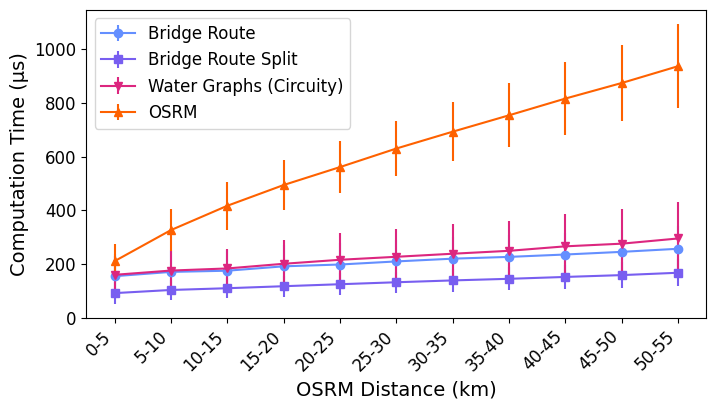

In [29]:
x = plotting_data['x']

color_list = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#FFB000']
marker_list = ['o', 's', 'v', '^', 'D', 'P']

for i, approach in enumerate(plotting_data['approach_names']):
    _y = plotting_data['avg'][approach]
    _y_errors = plotting_data['std'][approach]
    # plt.plot(x, _y, marker=marker_list[i], color=color_list[i], label=APPROACH_RENAMING_MAP[approach])
    plt.errorbar(x, _y, yerr=_y_errors, marker=marker_list[i], color=color_list[i], label=APPROACH_RENAMING_MAP[approach])

plt.legend(fontsize=12)

# change labels for x-axis
plt.xticks(x, plotting_data['x_names'], rotation=45, fontsize=12, ha='right')

plt.ylabel('Computation Time (µs)', fontsize=14)
plt.xlabel('OSRM Distance (km)', fontsize=14)

# add ticks for y-axis
plt.yticks(fontsize=12)

# set figure size
plt.gcf().set_size_inches(8, 4)

plt.savefig("Figures and Tables/ComputationTimePerRange.pdf", dpi=300, bbox_inches='tight')

## Calculation Time per Distance Range Table

In [30]:
tmp = measured_times.merge(distance_truth[['distance_meters', 'start_loc', 'dest_loc']], on=['start_loc', 'dest_loc'], suffixes=('', '_truth'))
tmp = tmp.merge(crosses_water_lookup, on=['start_loc', 'dest_loc'])

distance_ranges_times_results = get_times_per_range(tmp, DISTANCE_RANGES + [(1, 55_000)], scale_times_µs=True, crosses_river=False, as_string=True)

df = pd.DataFrame(distance_ranges_times_results).reset_index()
df = df.rename(columns={'index': 'approach'})

df = sort_by_approach(df)
df = df[df['Approach'].isin(["OSRM", "Overhead Graph (n=1024)", "Bridge Route", "Bridge Route Split", "Water Graphs (Circuity)"])]
df = df.T.reset_index()

df.columns = ['Distance (km)', 'OHG (n=1024)', 'OSRM', 'Bridge Route', 'Bridge Route Split', 'Water Graphs (Circuity)']
df = df.iloc[1:, :]
df['Distance (km)'] = df['Distance (km)'].apply(lambda x: f"{(int(x.split('-')[0])-1)/1000:.0f}-{(int(x.split('-')[1]))/1000:.0f}")

tex_file_name = "computation_time_per_distance_range"

df.style.hide(axis="index").format(decimal='.', thousands=',', precision=3, na_rep="-").to_latex(
    f"Figures and Tables/{tex_file_name}.tex", hrules=True)

df

,Distance (km),OHG (n=1024),OSRM,Bridge Route,Bridge Route Split,Water Graphs (Circuity)
1,0-5,6.61 ± 1.42,211.17 ± 65.42,155.27 ± 83.98,92.23 ± 40.37,160.33 ± 70.84
2,5-10,7.10 ± 1.37,326.78 ± 79.25,171.17 ± 81.54,103.92 ± 38.77,176.15 ± 73.96
...,...,...,...,...,...,...
11,50-55,8.07 ± 1.50,936.72 ± 156.98,257.25 ± 84.17,168.04 ± 49.30,295.59 ± 137.47
12,0-55,7.65 ± 1.52,610.35 ± 248.04,208.10 ± 87.00,131.55 ± 48.27,226.54 ± 112.03


# Computation Time Comparison WG vs OSRM

In [31]:
tmp = measured_times.merge(distance_truth[['distance_meters', 'start_loc', 'dest_loc']], on=['start_loc', 'dest_loc'], suffixes=('', '_truth'))
tmp = tmp.merge(crosses_water_lookup, on=['start_loc', 'dest_loc'])

tmp = tmp[['start_loc', 'dest_loc', 'approach', 'avg_time_ms', 'crosses_water', 'crosses_river', 'distance_meters']]
tmp = tmp[tmp['approach'].isin(['OSRM', 'WATER_GRAPH_CIRCUITY'])]

wg_times = tmp[tmp['approach'].isin(['WATER_GRAPH_CIRCUITY'])]
osrm_times = tmp[tmp['approach'].isin(['OSRM'])]

wg_times = wg_times.rename(columns={'avg_time_ms': 'avg_time_ms_wg'})
osrm_times = osrm_times.rename(columns={'avg_time_ms': 'avg_time_ms_osrm'})

tmp = wg_times.merge(osrm_times[['avg_time_ms_osrm', 'start_loc', 'dest_loc']], on=['start_loc', 'dest_loc'], suffixes=('', '_osrm'))
# tmp = tmp[(0 < tmp['distance_meters']) &  (tmp['distance_meters'] <= 5_000)]

print(tmp.shape)
tmp['relative_deviation'] = tmp['avg_time_ms_wg'] / tmp['avg_time_ms_osrm']
tmp[tmp['relative_deviation'] > 2]

(22092, 8)


,start_loc,dest_loc,approach,avg_time_ms_wg,crosses_water,crosses_river,distance_meters,avg_time_ms_osrm,relative_deviation
9,"Location[50.191687,9.736953]","Location[50.229999,9.755518]",WATER_GRAPH_CIRCUITY,0.358176,True,True,5888.399039,0.177789,2.014618
178,"Location[49.909169,10.182678]","Location[49.931855,10.17672]",WATER_GRAPH_CIRCUITY,0.264416,True,False,3257.653245,0.125159,2.112636
...,...,...,...,...,...,...,...,...,...
20550,"Location[49.772851,9.338743]","Location[49.759299,9.312282]",WATER_GRAPH_CIRCUITY,0.425324,True,True,3146.165991,0.192742,2.206694
21556,"Location[50.200316,9.733478]","Location[50.191687,9.736953]",WATER_GRAPH_CIRCUITY,0.336531,True,True,1472.835926,0.150276,2.239416
